In [265]:
import tweepy
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from wordcloud import WordCloud
from nltk.util import ngrams

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [266]:
# Add your Bearer token here.
client = tweepy.Client(bearer_token='')

# Create Pandas dataframe with three columns
tweet_df = pd.DataFrame(columns=['text', 'language'])

# Query tweets with #news. Show only 100 tweets
query = '#news'
tweets = client.search_recent_tweets(query=query, tweet_fields=['lang'], max_results=10)

for tweet in tweets.data:
    text = tweet.text
    language = tweet.lang

    # Focus only to tweets in english
    if language == 'en':
        tmp = [text, language]
        tweet_df.loc[len(tweet_df)] = tmp

# Total amount of tweets in dataframe
print('Amount: ', len(tweet_df))

# Show first 5 lines of dataframe
tweet_df.head()

Amount:  9


,text,language
0,RT @Ethica11y_Vegan: 🇺🇸🐒 TRANSGENDER MONKEY TR...,en
1,MONTE VISTA FIRE: Officials say there is no in...,en
2,@DefCafeSociety Guys get ready and load up now...,en
3,How to watch every season of American Horror S...,en
4,RT @etribune: The Pakistan Tehreek-e-Insaf (PT...,en


In [267]:
truenews = pd.read_csv("../files/True.csv")
fakenews = pd.read_csv("../files/Fake.csv")

truenews['label'] = 1
fakenews['label'] = 0

news_df = pd.concat([truenews, fakenews])
news_df = news_df.sample(frac = 1).reset_index(drop=True)
news_df.head()

,title,text,subject,date,label
0,Factbox: Many years of rhetoric reflect confli...,JERUSALEM (Reuters) - In the 50 years since Is...,worldnews,"December 6, 2017",1
1,BILL CLINTON’S RAPE ACCUSERS Speak Out: “We Ar...,Wow! These women are incredibly brave. Paula J...,left-news,"Oct 10, 2016",0
2,“White Student Union” Forms Facebook Page To O...,This Barack Obama-Eric Holder inspired anti-Am...,left-news,"Nov 21, 2015",0
3,Iran foreign minister scorns Trump after speec...,BEIRUT (Reuters) - Iranian Foreign Minister Mo...,politicsNews,"May 21, 2017",1
4,Trump Voter Whines That Her Husband Can’t Get...,When it comes to how horrible Donald Trump has...,News,"January 29, 2017",0


In [268]:
print("Does Twitter Dataframe contain null values: ", tweet_df.isnull().values.any())
print("Does News Dataframe contain null values: ", news_df.isnull().values.any(), "\n")

print("Twitter dataframe datatypes: \n", tweet_df.dtypes, "\n")
print("News dataframe datatypes: \n", news_df.dtypes)

Does Twitter Dataframe contain null values:  False
Does News Dataframe contain null values:  False 

Twitter dataframe datatypes: 
 text        object
language    object
dtype: object 

News dataframe datatypes: 
 title      object
text       object
subject    object
date       object
label       int64
dtype: object


In [269]:
def deEmojify(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

def clean_text(tweet):
    # Lower case text
    tweet = tweet.lower()

    # Remove mentions
    tweet = re.sub("@[A-Za-z0-9]+","", tweet)

    # Remove links
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)

    # Remove hastags
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)

    # Remove punctuations
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)

    tweet = re.sub(r"\b[a-zA-Z]\b", "", tweet)

    # Remove emoticons
    tweet = deEmojify(tweet)

    # Filter non-alphanumeric characters (double check...)
    tweet = re.sub("[^a-z0-9]"," ", tweet)

    # Tokenize tweet (split...)
    tokens = word_tokenize(tweet)

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    cleaned_tweet = ' '.join(tokens)

    return cleaned_tweet

test_text = "The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live"
print("Before: ", test_text)
print("After: ", clean_text(test_text))


Before:  The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live
After:  dragon endeavour four space astronauts hold 20 meter away station station crew work video rout issue


In [270]:
news_df['clean_text'] = np.nan

news_df['clean_text'] = [clean_text(x) for x in news_df['title']]

news_df.dropna(subset=['clean_text'], inplace=True)
news_df.drop_duplicates(subset=['text', 'clean_text'], keep=False, inplace=True)

news_df.head()

,title,text,subject,date,label,clean_text
0,Factbox: Many years of rhetoric reflect confli...,JERUSALEM (Reuters) - In the 50 years since Is...,worldnews,"December 6, 2017",1,factbox many years rhetoric reflect conflict j...
2,“White Student Union” Forms Facebook Page To O...,This Barack Obama-Eric Holder inspired anti-Am...,left-news,"Nov 21, 2015",0,white student union form facebook page organiz...
3,Iran foreign minister scorns Trump after speec...,BEIRUT (Reuters) - Iranian Foreign Minister Mo...,politicsNews,"May 21, 2017",1,iran foreign minister scorn trump speech arm deal
4,Trump Voter Whines That Her Husband Can’t Get...,When it comes to how horrible Donald Trump has...,News,"January 29, 2017",0,trump voter whine husband get back country tweet
5,Everyone KNEW Trump Would Be Golfing Again – ...,There are only three things for certain in thi...,News,"April 8, 2017",0,everyone know trump would golf protesters tota...


In [271]:
tweet_df['clean_text'] = np.nan

tweet_df['clean_text'] = [clean_text(x) for x in tweet_df['text']]

tweet_df.dropna(subset=['clean_text'], inplace=True)
tweet_df.drop_duplicates(subset=['text', 'clean_text'], keep=False, inplace=True)

tweet_df.head()

,text,language,clean_text
0,RT @Ethica11y_Vegan: 🇺🇸🐒 TRANSGENDER MONKEY TR...,en,rt vegan transgender monkey trials propose nih...
1,MONTE VISTA FIRE: Officials say there is no in...,en,monte vista fire officials say indication fire...
2,@DefCafeSociety Guys get ready and load up now...,en,guy get ready load one trajectory
3,How to watch every season of American Horror S...,en,watch every season american horror story detai...
4,RT @etribune: The Pakistan Tehreek-e-Insaf (PT...,en,rt pakistan tehreek insaf pti grand power show...


In [272]:
clean_text_combined = pd.concat([news_df['clean_text'], tweet_df['clean_text']])
clean_text_combined.head()
print("All clean texts combined size: ", clean_text_combined.size)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_text_combined)

def tokenize(text):
    tmp_text = tokenizer.texts_to_sequences(text)
    tmp_text = pad_sequences(tmp_text, padding='post', maxlen=232)
    return tmp_text

All clean texts combined size:  33798


In [273]:
tweet_df['sequence'] = np.nan
tweet_df['sequence'] = list(tokenize(tweet_df['clean_text']))

tweet_df.head()

,text,language,clean_text,sequence
0,RT @Ethica11y_Vegan: 🇺🇸🐒 TRANSGENDER MONKEY TR...,en,rt vegan transgender monkey trials propose nih...,"[4179, 14709, 527, 3941, 14710, 454, 14711, 99..."
1,MONTE VISTA FIRE: Officials say there is no in...,en,monte vista fire officials say indication fire...,"[14712, 14713, 93, 189, 2, 5525, 93, 14714, 62..."
2,@DefCafeSociety Guys get ready and load up now...,en,guy get ready load one trajectory,"[918, 13, 361, 4582, 60, 14715, 0, 0, 0, 0, 0,..."
3,How to watch every season of American Horror S...,en,watch every season american horror story detai...,"[8, 811, 3767, 222, 3756, 950, 153, 14716, 0, ..."
4,RT @etribune: The Pakistan Tehreek-e-Insaf (PT...,en,rt pakistan tehreek insaf pti grand power show...,"[4179, 515, 14717, 14718, 9474, 1906, 266, 58,..."


In [274]:
news_df['sequence'] = np.nan
news_df['sequence'] = list(tokenize(news_df['clean_text']))

news_df.head()

,title,text,subject,date,label,clean_text,sequence
0,Factbox: Many years of rhetoric reflect confli...,JERUSALEM (Reuters) - In the 50 years since Is...,worldnews,"December 6, 2017",1,factbox many years rhetoric reflect conflict j...,"[80, 969, 282, 1369, 3932, 954, 254, 0, 0, 0, ..."
2,“White Student Union” Forms Facebook Page To O...,This Barack Obama-Eric Holder inspired anti-Am...,left-news,"Nov 21, 2015",0,white student union form facebook page organiz...,"[7, 970, 854, 1522, 542, 1493, 3675, 697, 2265..."
3,Iran foreign minister scorns Trump after speec...,BEIRUT (Reuters) - Iranian Foreign Minister Mo...,politicsNews,"May 21, 2017",1,iran foreign minister scorn trump speech arm deal,"[47, 125, 53, 5534, 1, 123, 376, 36, 0, 0, 0, ..."
4,Trump Voter Whines That Her Husband Can’t Get...,When it comes to how horrible Donald Trump has...,News,"January 29, 2017",0,trump voter whine husband get back country tweet,"[1, 382, 598, 1064, 13, 39, 530, 18, 0, 0, 0, ..."
5,Everyone KNEW Trump Would Be Golfing Again – ...,There are only three things for certain in thi...,News,"April 8, 2017",0,everyone know trump would golf protesters tota...,"[939, 259, 1, 104, 983, 341, 1219, 361, 58, 0,..."


In [275]:
train_df, test_df = train_test_split(news_df, test_size=0.2)
train_df.head()

,title,text,subject,date,label,clean_text,sequence
33649,"Cruz returns to Washington, warns of 'volcanic...",WASHINGTON (Reuters) - Former Republican presi...,politicsNews,"May 10, 2016",1,cruz return washington warn volcanic anger,"[91, 262, 372, 107, 4492, 1489, 0, 0, 0, 0, 0,..."
21082,ALERT: Republicans Push Bill To Split Ninth C...,Republicans are now gunning for the Ninth Circ...,News,"February 9, 2017",0,alert republicans push bill split ninth circui...,"[1681, 32, 193, 14, 1316, 8892, 3946, 22, 225,..."
2995,WATCH: Maxine Waters Starts Disgusting Chant A...,The Women s Convention in Detroit brings to mi...,politics,"Oct 29, 2017",0,watch maxine water start disgust chant women c...,"[8, 1701, 386, 270, 732, 1466, 142, 595, 640, ..."
11718,China jails 21 people for 2015 nursing home fi...,SHANGHAI (Reuters) - China has jailed 21 peopl...,worldnews,"December 8, 2017",1,china jail 21 people 2015 nurse home fire xinhua,"[25, 302, 2259, 85, 1817, 3215, 370, 93, 2408,..."
31863,Trump picks longtime friend of Beijing as U.S....,BEIJING/NEW YORK (Reuters) - President-elect D...,politicsNews,"December 7, 2016",1,trump pick longtime friend beijing ambassador ...,"[1, 143, 3383, 1351, 1248, 571, 25, 0, 0, 0, 0..."


In [276]:
tokenized_counts = Counter(tokenizer.word_counts)
tokenized_df = pd.DataFrame([tokenized_counts.keys(), tokenized_counts.values()]).T
tokenized_df.columns=['word', 'quantity']
tokenized_df = tokenized_df.sort_values(by='quantity', ascending=False)

tokenized_df.head(10)

,word,quantity
24,trump,11759
54,say,3809
116,video,2882
124,house,1785
132,obama,1690
383,new,1304
7,white,1292
658,watch,1263
76,clinton,1193
72,russia,1166


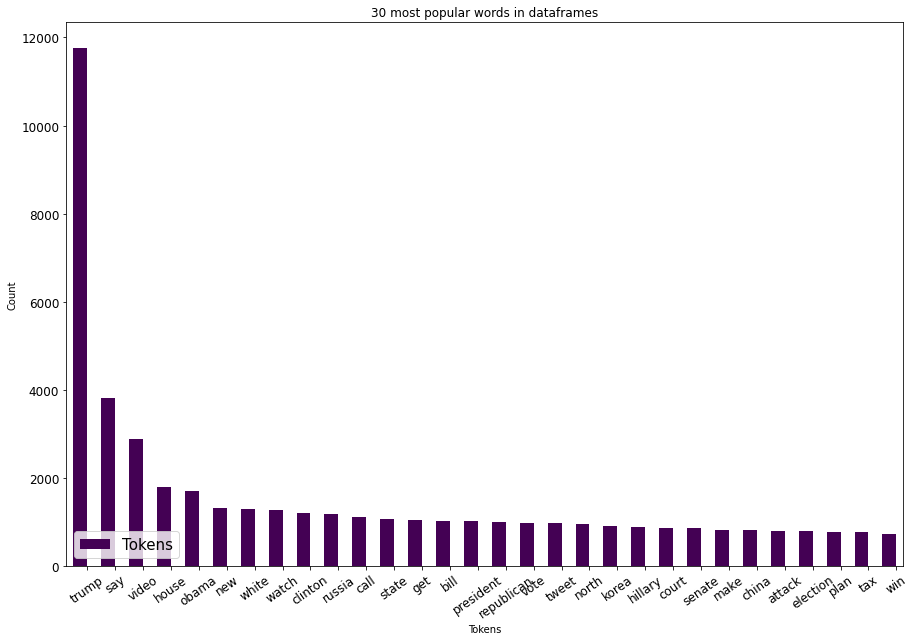

In [277]:
tokenized_df[:30].plot(kind="bar",x="word", orientation="vertical", figsize=(15,10), xlabel="Tokens", ylabel="Count", colormap="viridis", table=False, grid=False, fontsize=12, rot=35, position=1, title="30 most popular words in dataframes", legend=True).legend(["Tokens"], loc="lower left", prop={"size":15})

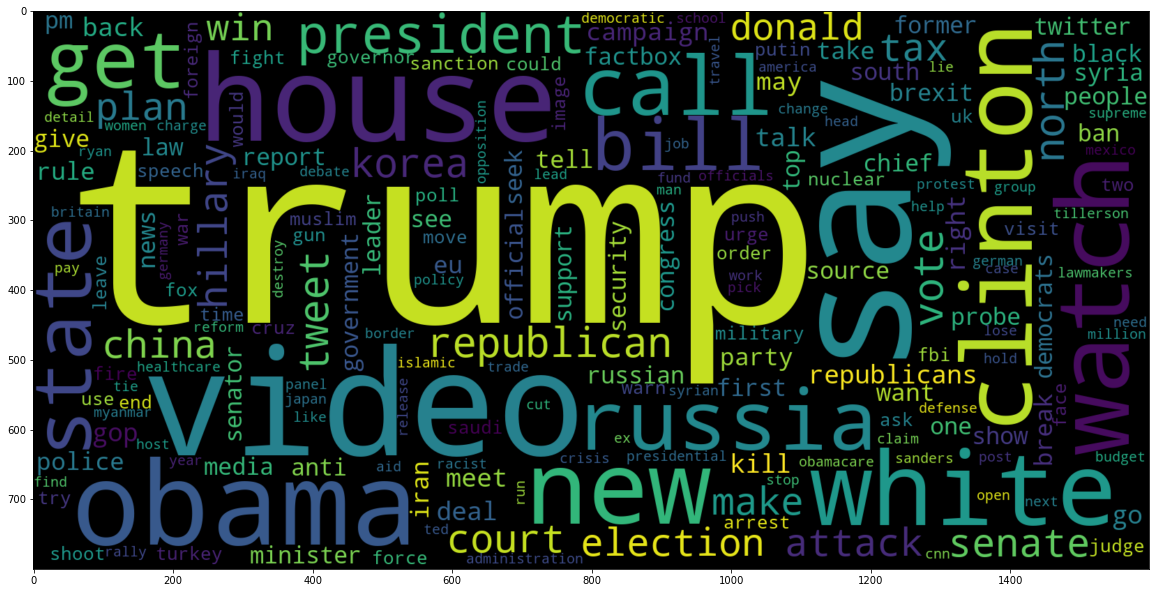

In [278]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words= 200, width = 1600, height= 800).generate_from_frequencies(tokenized_counts)
plt.imshow(wc, interpolation = 'bilinear')

<AxesSubplot:title={'center':'Longest 200 tweet/news lengths'}, xlabel='index', ylabel='word count'>

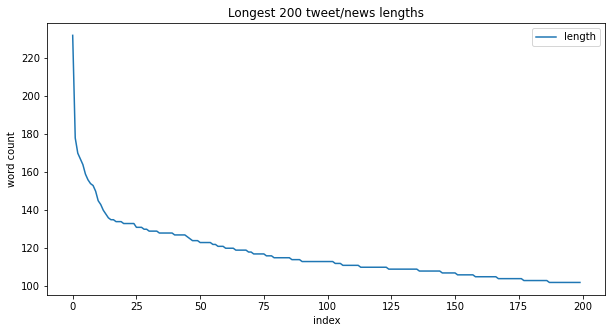

In [279]:
length_df = pd.DataFrame(columns=['length'])
length_df['length'] = [len(i) for i in clean_text_combined]
length_df.sort_values(by=['length'], inplace=True, ascending=False)
length_df = length_df.reset_index(drop=True)
length_df[:200].plot(title="Longest 200 tweet/news lengths", figsize=(10,5), xlabel='index', ylabel='word count')

<AxesSubplot:>

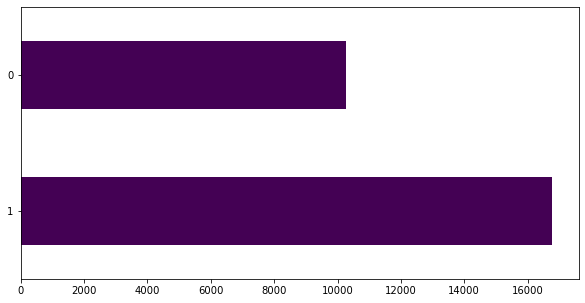

In [280]:
train_df['label'].value_counts().plot(kind='barh', figsize=(10,5), colormap="viridis")

<AxesSubplot:>

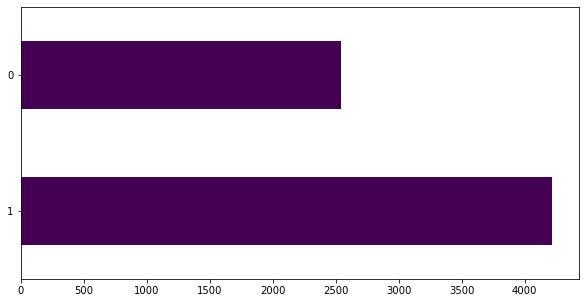

In [281]:
test_df['label'].value_counts().plot(kind='barh', figsize=(10,5), colormap="viridis")

In [282]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform([x for x in clean_text_combined])
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,2.079128
say,3.186747
video,3.473814
house,3.963104
obama,4.002829
...,...
kratz,10.735039
reunion,10.735039
reunification,10.735039
enlightenment,10.735039


<AxesSubplot:>

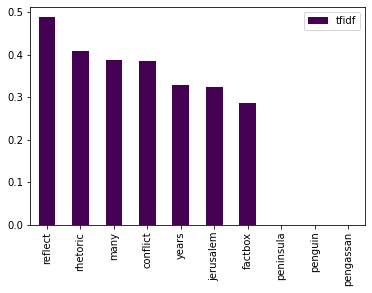

In [283]:
count_vector = cv.transform([x for x in clean_text_combined])
tf_idf_vector = tfidf_transformer.transform(count_vector)

feature_names = cv.get_feature_names_out()
first_document_vector=tf_idf_vector[0] 
tf_idf_df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
tf_idf_df = tf_idf_df.sort_values(by=["tfidf"],ascending=False)
tf_idf_df[:10].plot(kind="bar", colormap="viridis")

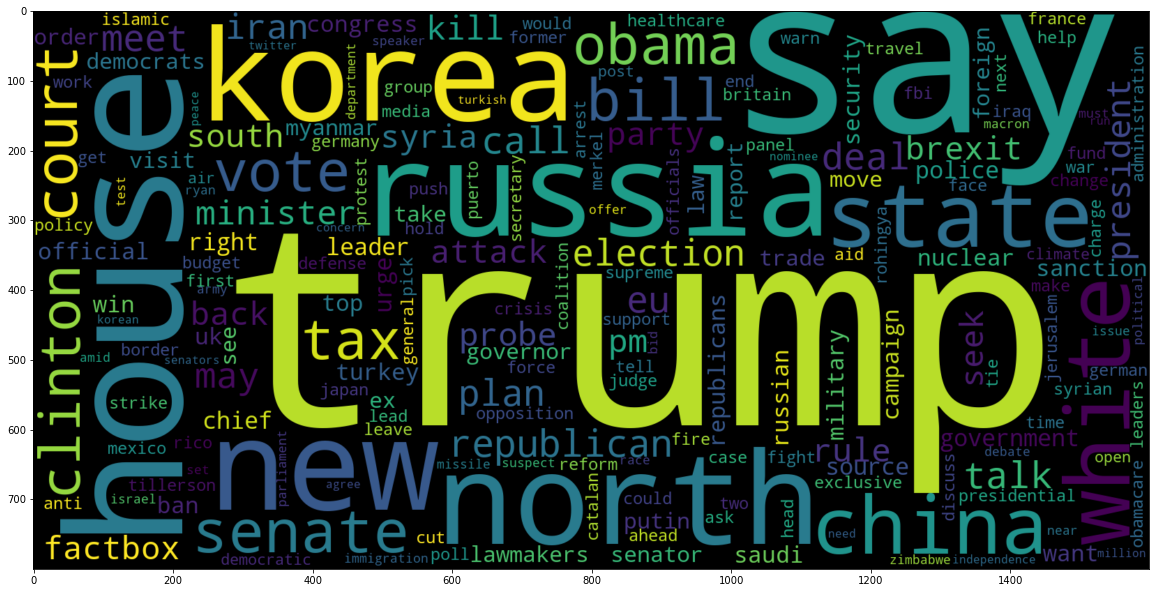

In [284]:
plt.figure(figsize=(20,20))
true_df = news_df[news_df['label'] == 1]
tokenizer_true = Tokenizer()
tokenizer_true.fit_on_texts([x for x in true_df['clean_text']])
tokenized_counts_true = Counter(tokenizer_true.word_counts)
wc_true = WordCloud(max_words= 200, width = 1600, height= 800).generate_from_frequencies(tokenized_counts_true)
plt.imshow(wc_true, interpolation = 'bilinear')

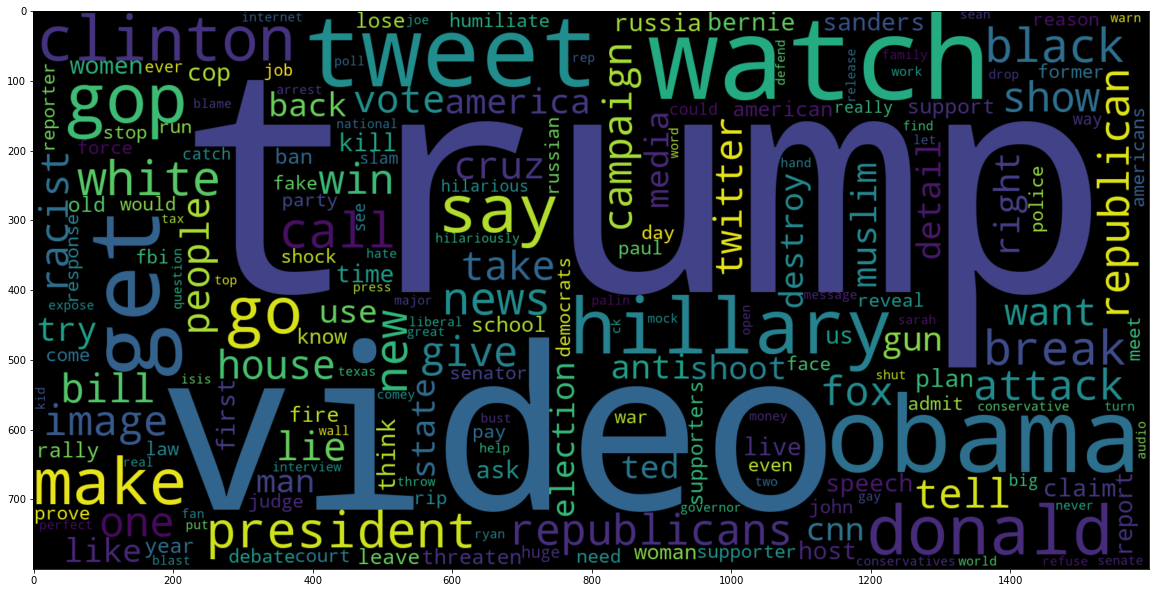

In [285]:
plt.figure(figsize=(20,20))
false_df = news_df[news_df['label'] == 0]
tokenizer_false = Tokenizer()
tokenizer_false.fit_on_texts([x for x in false_df['clean_text']])
tokenized_counts_false = Counter(tokenizer_false.word_counts)
wc_false = WordCloud(max_words= 200, width = 1600, height= 800).generate_from_frequencies(tokenized_counts_false)
plt.imshow(wc_false, interpolation = 'bilinear')

<AxesSubplot:title={'center':'20 Most frequently Occuring Bigrams (True Dataset)'}, ylabel='Bigram'>

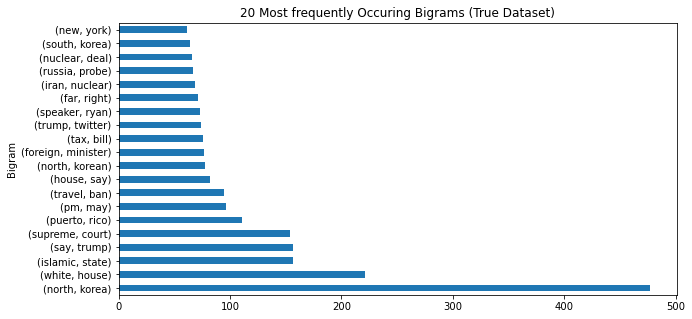

In [305]:
true_word = ''.join(true_df['clean_text'].tolist())
true_bigrams_series = pd.Series(ngrams(true_word.split(), 2))
true_bigrams_series = true_bigrams_series.value_counts()
true_bigrams_series = true_bigrams_series.sort_values(ascending=False)
true_bigrams_series[:20].plot(kind='barh', figsize=(10,5), xlabel='Bigram', ylabel='# of Occurances', title='20 Most frequently Occuring Bigrams (True Dataset)')

<AxesSubplot:title={'center':'20 Most frequently Occuring Bigrams (False Dataset)'}, ylabel='Bigram'>

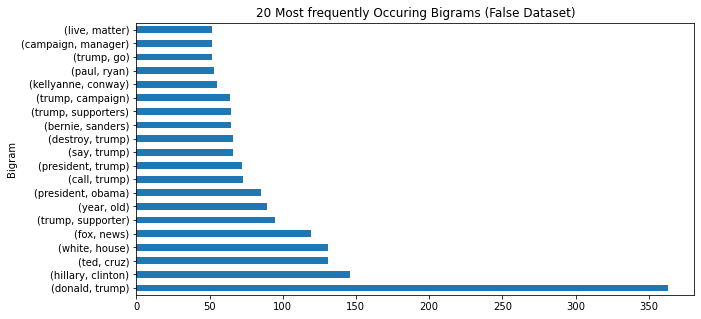

In [304]:
false_word = ''.join(false_df['clean_text'].tolist())
false_bigrams_series = pd.Series(ngrams(false_word.split(), 2))
false_bigrams_series = false_bigrams_series.value_counts()
false_bigrams_series = false_bigrams_series.sort_values(ascending=False)
false_bigrams_series[:20].plot(kind='barh', figsize=(10,5), xlabel='Bigram', ylabel='# of Occurances', title='20 Most frequently Occuring Bigrams (False Dataset)')